In [1]:
import os
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
%cd ..

/home/luana/Bureau/finances


## Verification du biais

In [3]:
from data_loaders import DataLoader
from data_trainers import DataTrainer

loader = DataLoader()

trainer = DataTrainer(loader)

In [4]:
trainer.set_logistic_regression()
trainer.train_state('TX')

y_pred = trainer.test_model()
y_pred

/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([False, False,  True, ..., False, False, False])

In [5]:
df_test = loader.X_test.copy()
df_test['prediction'] = y_pred
df_man = df_test[df_test['SEX'] == 1]
df_woman = df_test[df_test['SEX'] == 2]

In [6]:
df_man_true = df_man[df_man['prediction'] == True]
df_man_false = df_man[df_man['prediction'] == False]
print(df_man_true['prediction'].count())
print(df_man_false['prediction'].count())

3095
4100


In [7]:
df_woman_true = df_woman[df_woman['prediction'] == True]
df_woman_false = df_woman[df_woman['prediction'] == False]
print(df_woman_true['prediction'].count())
print(df_woman_false['prediction'].count())

1299
5099


### On vérifie la difference entre prediction d'hommes et femmes qui reçoivent > 50000

In [8]:
df_woman_true['prediction'].count()/df_man_true['prediction'].count()

0.4197092084006462

In [9]:
df_woman_false['prediction'].count()/df_man_false['prediction'].count()

1.2436585365853658

## Analysis des Anchors

In [10]:
# tem feature duplicada??

In [11]:
def plot_sex_anchors_comparison(true_pred, false_pred, title_suffix=""):
    # Map anchor's labels
    labels_map = {
        'SEX <= 1.00': 'Male (SEX=1)',
        'SEX > 1.00': 'Female (SEX>1)',
        'SEX <= 2.00': 'Female (SEX=2)'
    }
    
    # Process data
    categories = ['Male (SEX=1)', 'Female (SEX>1)', 'Both (SEX<=2)']
    true_counts = [true_pred.get('SEX <= 1.00', 0), 
                   true_pred.get('SEX > 1.00', 0), 
                   true_pred.get('SEX <= 2.00', 0)]
    false_counts = [false_pred.get('SEX <= 1.00', 0), 
                    false_pred.get('SEX > 1.00', 0), 
                    false_pred.get('SEX <= 2.00', 0)]
    
    # Configure graphic
    x = np.arange(len(categories))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(8, 4))
    rects1 = ax.bar(x - width/2, true_counts, width, label='True Predictions', color='#ff7f0e')
    rects2 = ax.bar(x + width/2, false_counts, width, label='False Predictions', color='#1f77b4')
    
    # Adiciona texto e formatação
    ax.set_ylabel('Anchors count')
    ax.set_title(f"Distribution of Anchors by SEX feature: {title_suffix}")
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    
    # Adiciona valores nas barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.show()

In [12]:
def analyse_sex_anchors(dados, cond = [], cond_value = []):
    if len(cond) != len(cond_value):
        raise ValueError("As listas 'cond' e 'cond_value' devem ter o mesmo tamanho")
        
    sex_anchors = dict()
    for chave, valor in dados.items():
        all_cond = True
        if len(cond) != 0:
            for c, v in zip(cond, cond_value):
                if c == 'precision':
                    condition = valor.get('precision') > v
                elif c == 'prediction':
                    condition = valor.get('prediction') == v
                elif c == 'coverage':
                    condition = valor.get('coverage') > v
                elif c == 'num_features':
                    condition = len(valor.get('features')) <= v
                else:
                    condition = True
                all_cond = all_cond and condition
        
        if all_cond:
            for f in valor.get('features'):
                if f.get('feature_name') == 'SEX':
                    feature_range = f.get('feature_ranges')
                        
                    if feature_range not in sex_anchors:
                        sex_anchors[feature_range] = 0
                    
                    sex_anchors[feature_range] += 1

    return sex_anchors

In [13]:
# HOMME - 1
# FEMME - 2

def analyse_anchors(file_path, bool_label = 'str'):
    with open(file_path, 'r', encoding='utf-8') as f:
        dados = json.load(f)
    
    print("Total of test data: ", len(dados.items()))
    
    sex = {
        'femme': 0,
        'homme': 0
    }
    
    for chave, valor in dados.items():        
        for f in valor.get('features'):
            if f.get('feature_name') == 'SEX':
                if f.get('feature_value') == 1:
                    sex['homme'] += 1
                else:
                    sex['femme'] += 1

    print("Total of anchors of men: ", sex['homme'])
    print("Total of anchors of women: ", sex['femme'])

    if bool_label == 'str':
        true_label = "True"
        false_label = "False"
    else:
        true_label = 1
        false_label = 0
    
    true = analyse_sex_anchors(dados, ['prediction'], [true_label])
    false = analyse_sex_anchors(dados, ['prediction'], [false_label])
    print(f"For true predictions: {true} \nFor false predictions: {false}")
    plot_sex_anchors_comparison(true, false, "prediction = 'True'/'False'")
    
    true = analyse_sex_anchors(dados, ['prediction', 'coverage'], [true_label, 0.2])
    false = analyse_sex_anchors(dados, ['prediction', 'coverage'], [false_label, 0.2])
    print(f"For true predictions and coverage > 0.2: {true} \nFor false predictions and coverage > 0.2: {false}")
    plot_sex_anchors_comparison(true, false, "prediction = 'True'/'False'; coverage > 0.2")
    
    true = analyse_sex_anchors(dados, ['prediction', 'precision'], [true_label, 0.95])
    false = analyse_sex_anchors(dados, ['prediction', 'precision'], [false_label, 0.95])
    print(f"For true predictions and precision > 0.95: {true} \nFor false predictions and precision > 0.95: {false}")
    plot_sex_anchors_comparison(true, false, "prediction = 'True'/'False'; precision > 0.95")
    
    true = analyse_sex_anchors(dados, ['prediction', 'num_features'], [true_label, 3])
    false = analyse_sex_anchors(dados, ['prediction', 'num_features'], [false_label, 3])
    print(f"For true predictions and num_features <= 3: {true} \nFor false predictions and num_features <= 3: {false}")
    plot_sex_anchors_comparison(true, false, "prediction = 'True'/'False'; num_features <= 3")
    
    true = analyse_sex_anchors(dados, ['prediction', 'precision', 'coverage'], [true_label, 0.95, 0.2])
    false = analyse_sex_anchors(dados, ['prediction', 'precision', 'coverage'], [false_label, 0.95, 0.2])
    print(f"For true predictions and precision > 0.95 and coverage > 0.2: {true} \nFor false predictions and precision > 0.95 and coverage > 0.2: {false}")
    plot_sex_anchors_comparison(true, false, "prediction = 'True'/'False'; precision > 0.95; coverage > 0.2")

### État de Texas - modèle Logistic Regression

Total of test data:  13593
Total of anchors of men:  1766
Total of anchors of women:  1949
For true predictions: {'SEX <= 1.00': 1759, 'SEX <= 2.00': 29} 
For false predictions: {'SEX > 1.00': 1920, 'SEX <= 2.00': 7}


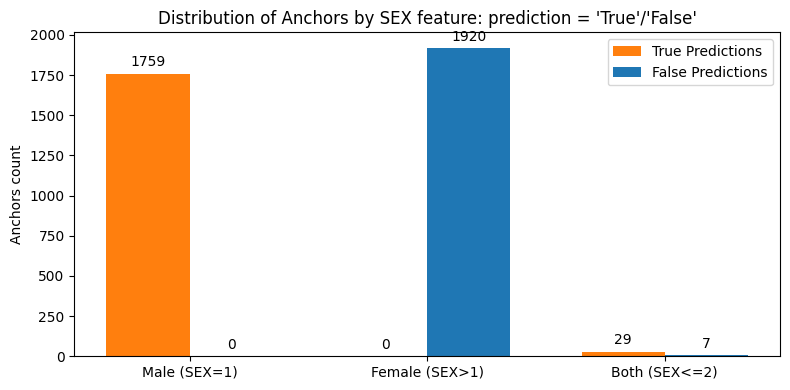

For true predictions and coverage > 0.2: {} 
For false predictions and coverage > 0.2: {'SEX > 1.00': 284}


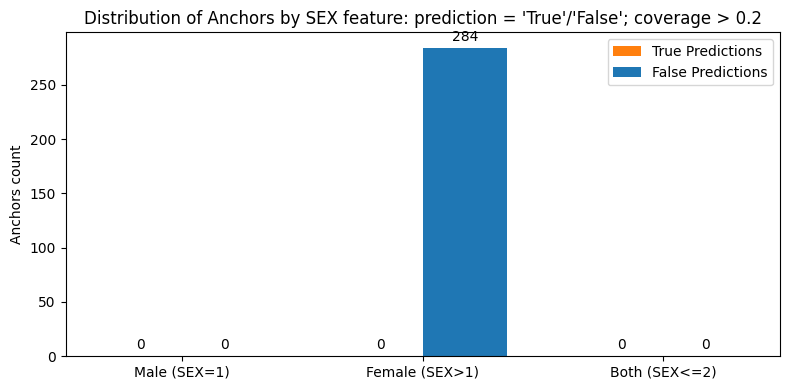

For true predictions and precision > 0.95: {'SEX <= 1.00': 1676, 'SEX <= 2.00': 6} 
For false predictions and precision > 0.95: {'SEX > 1.00': 1920, 'SEX <= 2.00': 5}


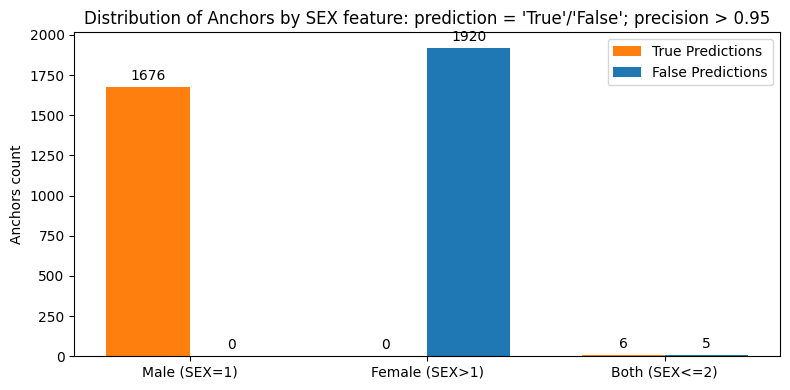

For true predictions and num_features <= 3: {'SEX <= 1.00': 51} 
For false predictions and num_features <= 3: {'SEX > 1.00': 1868}


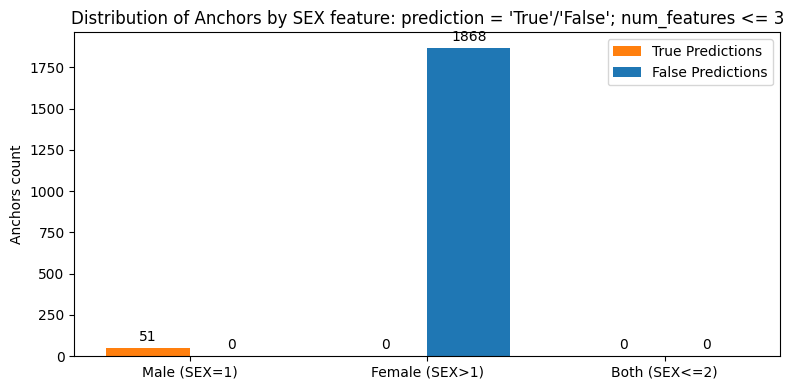

For true predictions and precision > 0.95 and coverage > 0.2: {} 
For false predictions and precision > 0.95 and coverage > 0.2: {'SEX > 1.00': 284}


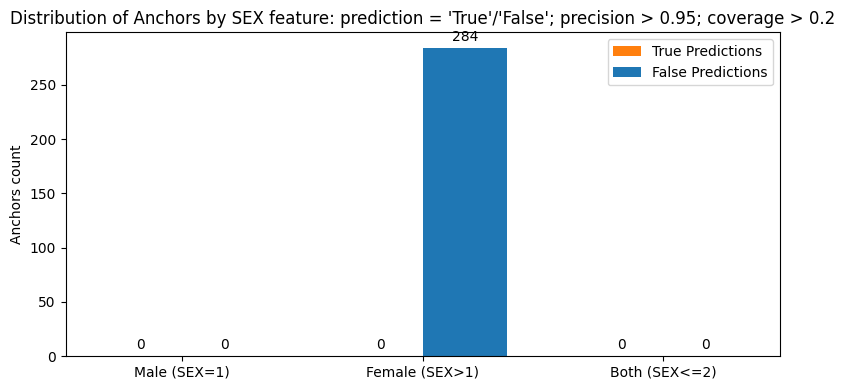

In [14]:
file = 'xai/output/json/lr_tx_anchors_explanations.json'
analyse_anchors(file)

### État de Texas - modèle XGBoost

Total of test data:  13593
Total of anchors of men:  2239
Total of anchors of women:  1960
For true predictions: {'SEX <= 1.00': 2147, 'SEX <= 2.00': 282} 
For false predictions: {'1.00 < SEX <= 2.00': 37, 'SEX > 1.00': 1639, 'SEX <= 2.00': 90, 'SEX <= 1.00': 4}


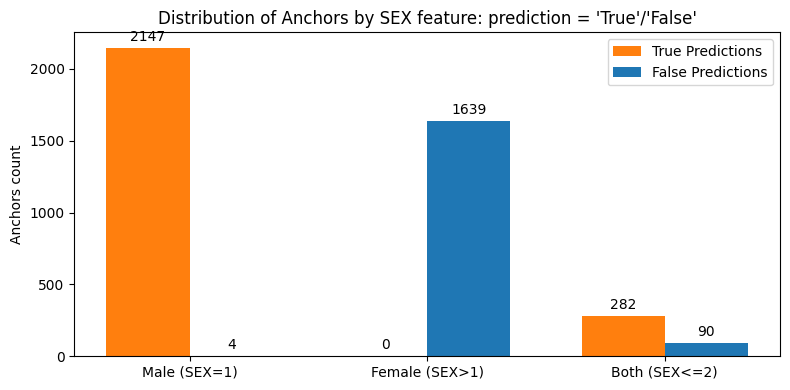

For true predictions and coverage > 0.2: {'SEX <= 1.00': 2} 
For false predictions and coverage > 0.2: {'SEX > 1.00': 73, 'SEX <= 2.00': 6, '1.00 < SEX <= 2.00': 1}


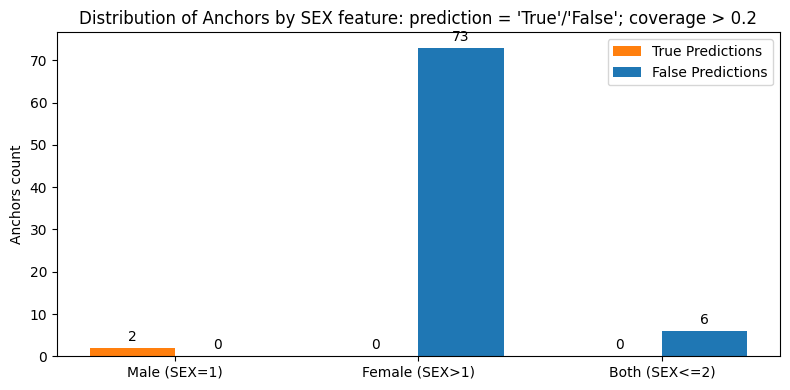

For true predictions and precision > 0.95: {'SEX <= 1.00': 1509, 'SEX <= 2.00': 7} 
For false predictions and precision > 0.95: {'SEX > 1.00': 1615, 'SEX <= 2.00': 16, '1.00 < SEX <= 2.00': 10, 'SEX <= 1.00': 3}


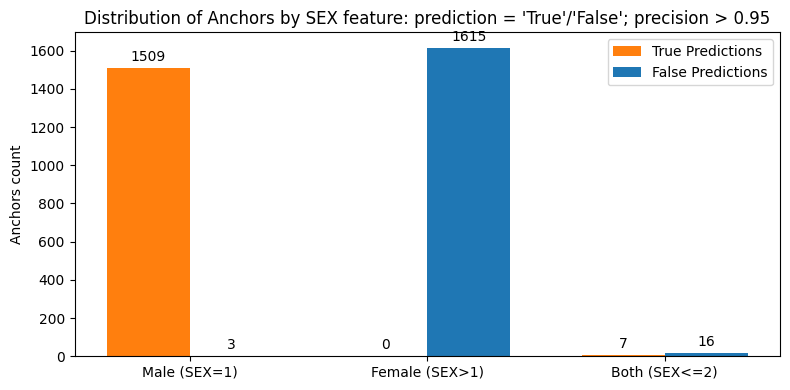

For true predictions and num_features <= 3: {'SEX <= 1.00': 1} 
For false predictions and num_features <= 3: {'SEX > 1.00': 1215}


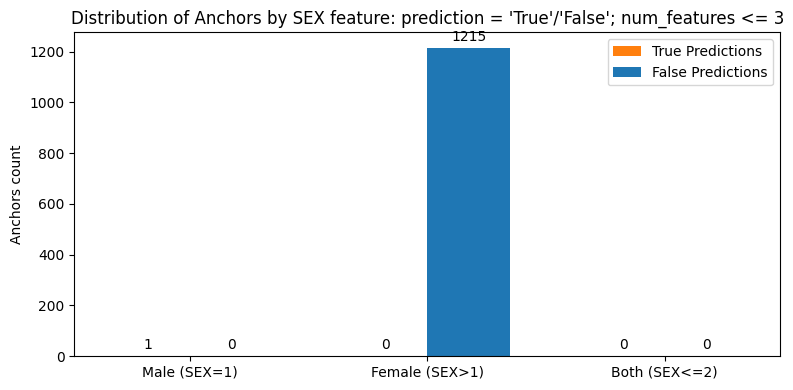

For true predictions and precision > 0.95 and coverage > 0.2: {} 
For false predictions and precision > 0.95 and coverage > 0.2: {'SEX > 1.00': 66}


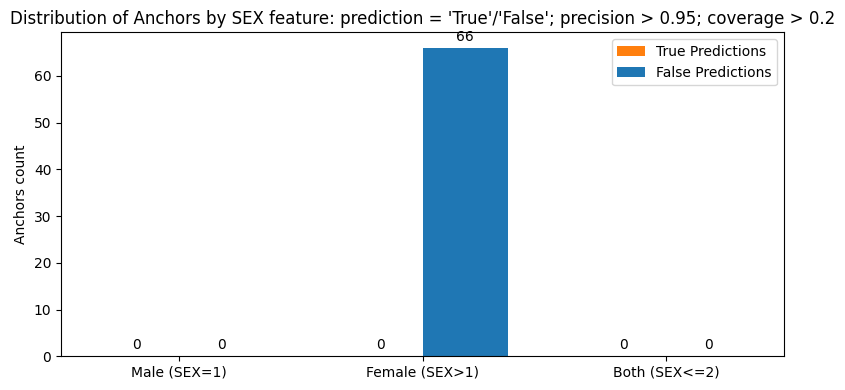

In [15]:
file = 'xai/output/json/xg_tx_anchors_explanations.json'
analyse_anchors(file, 'num')

### État de California - modèle Logistic Regression

Total of test data:  19567
Total of anchors of men:  1254
Total of anchors of women:  825
For true predictions: {'SEX <= 1.00': 1242, 'SEX <= 2.00': 42} 
For false predictions: {'SEX > 1.00': 778, '1.00 < SEX <= 2.00': 8, 'SEX <= 2.00': 9}


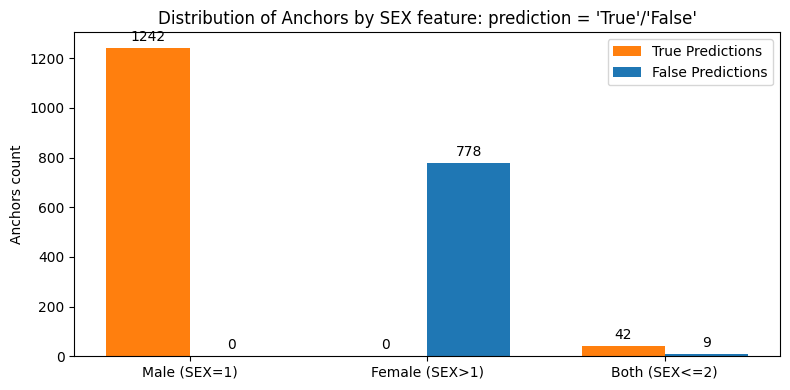

For true predictions and coverage > 0.2: {} 
For false predictions and coverage > 0.2: {'SEX > 1.00': 1}


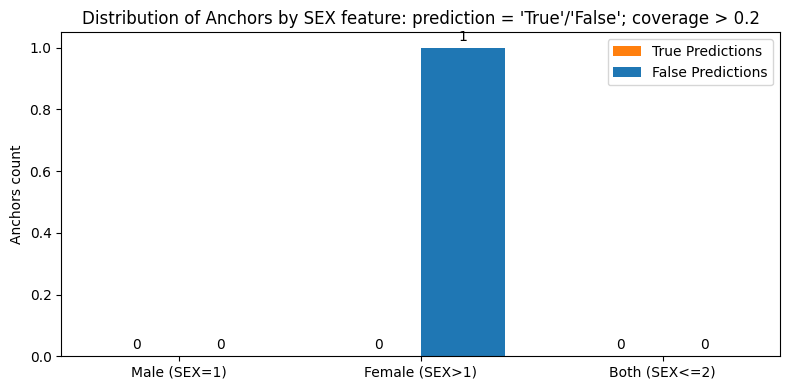

For true predictions and precision > 0.95: {'SEX <= 1.00': 1186, 'SEX <= 2.00': 6} 
For false predictions and precision > 0.95: {'SEX > 1.00': 776, '1.00 < SEX <= 2.00': 2}


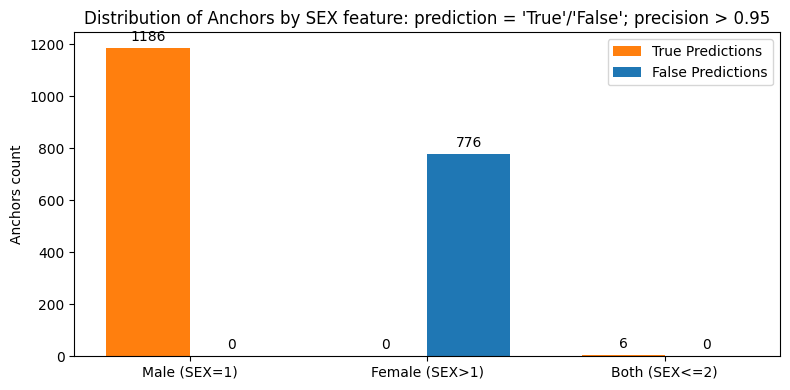

For true predictions and num_features <= 3: {'SEX <= 1.00': 36} 
For false predictions and num_features <= 3: {'SEX > 1.00': 564}


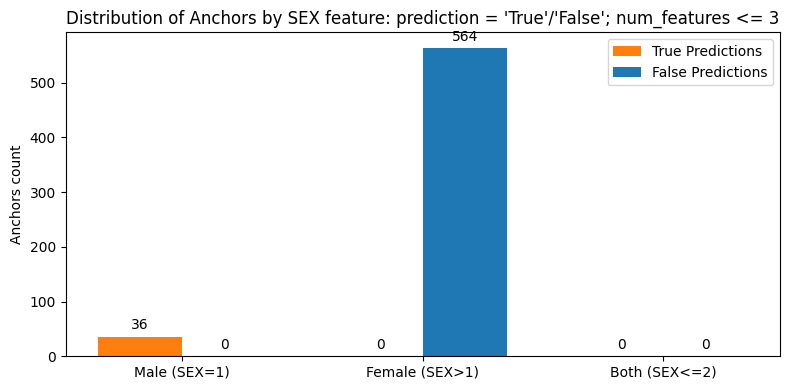

For true predictions and precision > 0.95 and coverage > 0.2: {} 
For false predictions and precision > 0.95 and coverage > 0.2: {'SEX > 1.00': 1}


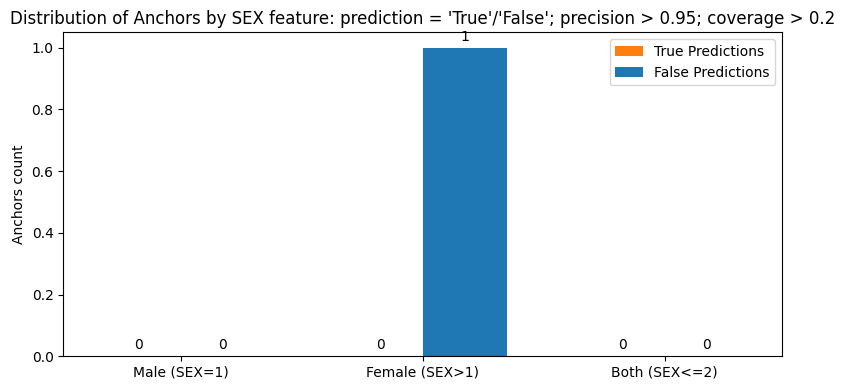

In [16]:
file = 'xai/output/json/lr_ca_anchors_explanations.json'
analyse_anchors(file)

### État de California - modèle XGBoost

Total of test data:  19567
Total of anchors of men:  2303
Total of anchors of women:  1601
For true predictions: {'SEX <= 1.00': 2209, 'SEX <= 2.00': 329} 
For false predictions: {'SEX > 1.00': 1176, '1.00 < SEX <= 2.00': 85, 'SEX <= 2.00': 95, 'SEX <= 1.00': 10}


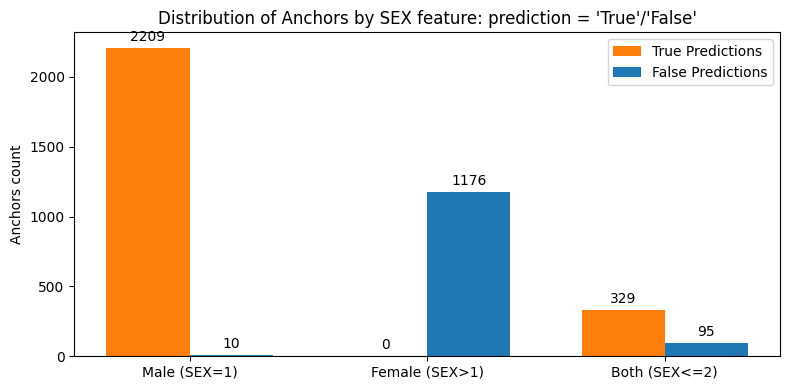

For true predictions and coverage > 0.2: {'SEX <= 2.00': 4} 
For false predictions and coverage > 0.2: {'SEX > 1.00': 1, 'SEX <= 2.00': 4}


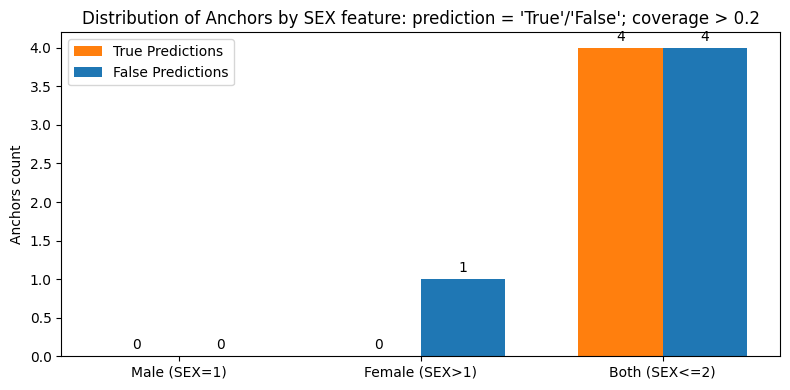

For true predictions and precision > 0.95: {'SEX <= 1.00': 1654, 'SEX <= 2.00': 7} 
For false predictions and precision > 0.95: {'SEX > 1.00': 1098, '1.00 < SEX <= 2.00': 18, 'SEX <= 2.00': 6, 'SEX <= 1.00': 4}


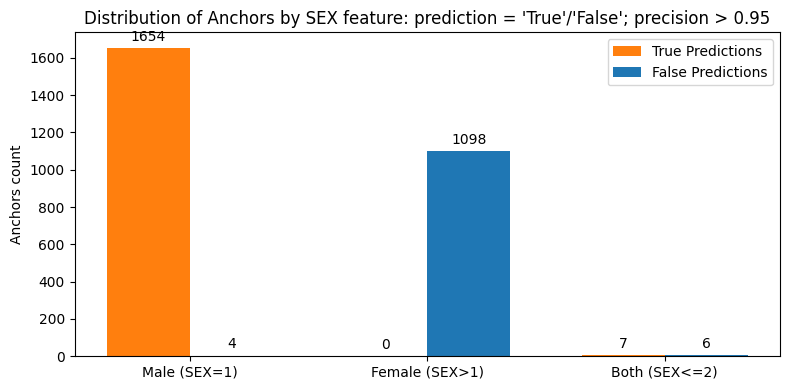

For true predictions and num_features <= 3: {'SEX <= 1.00': 21} 
For false predictions and num_features <= 3: {'SEX > 1.00': 395}


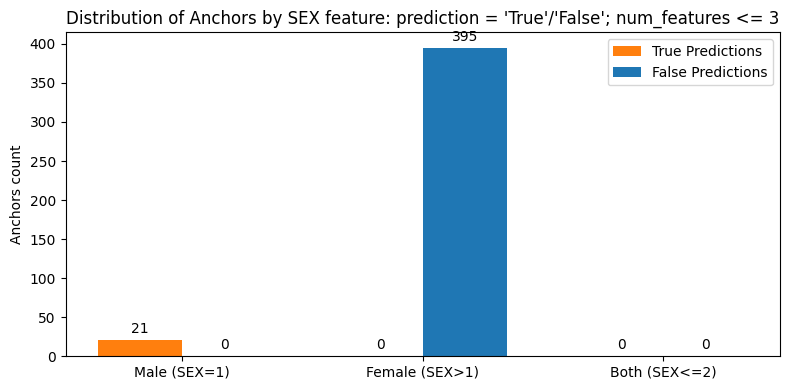

For true predictions and precision > 0.95 and coverage > 0.2: {} 
For false predictions and precision > 0.95 and coverage > 0.2: {}


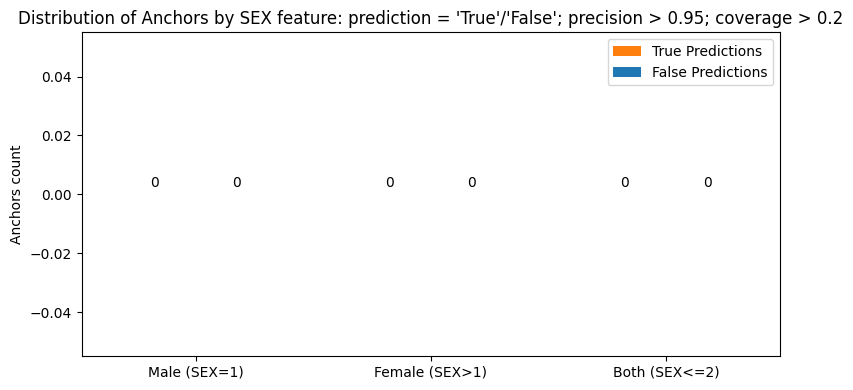

In [17]:
file = 'xai/output/json/xg_ca_anchors_explanations.json'
analyse_anchors(file, 'num')

### État de New York - modèle Logistic Regression

Total of test data:  10303
Total of anchors of men:  670
Total of anchors of women:  543
For true predictions: {'SEX <= 1.00': 664, 'SEX <= 2.00': 51} 
For false predictions: {'SEX > 1.00': 482, '1.00 < SEX <= 2.00': 10, 'SEX <= 2.00': 6}


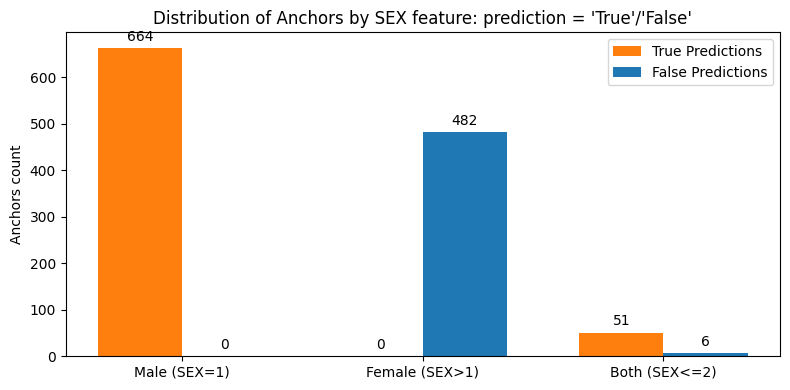

For true predictions and coverage > 0.2: {} 
For false predictions and coverage > 0.2: {'SEX > 1.00': 1}


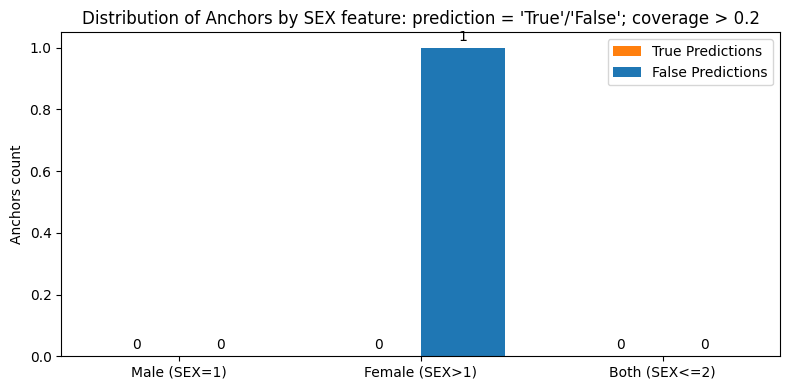

For true predictions and precision > 0.95: {'SEX <= 1.00': 606, 'SEX <= 2.00': 6} 
For false predictions and precision > 0.95: {'SEX > 1.00': 473, '1.00 < SEX <= 2.00': 4}


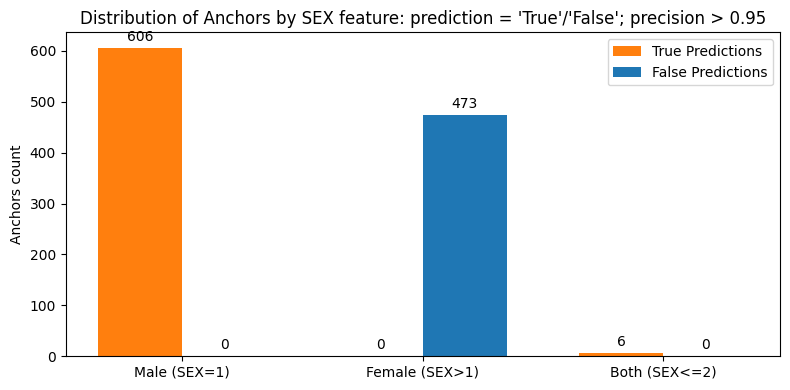

For true predictions and num_features <= 3: {'SEX <= 1.00': 26} 
For false predictions and num_features <= 3: {'SEX > 1.00': 361}


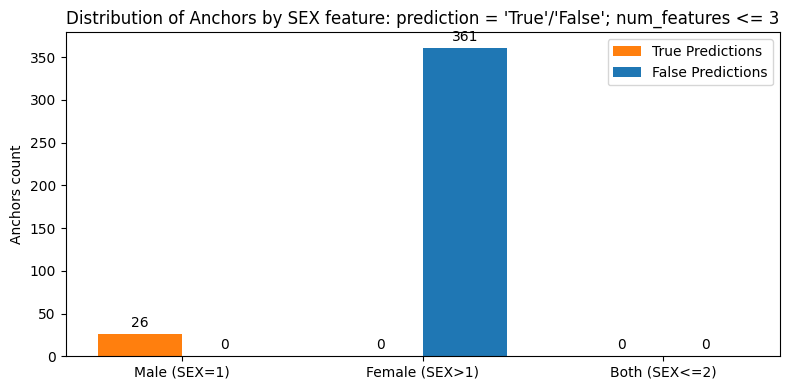

For true predictions and precision > 0.95 and coverage > 0.2: {} 
For false predictions and precision > 0.95 and coverage > 0.2: {'SEX > 1.00': 1}


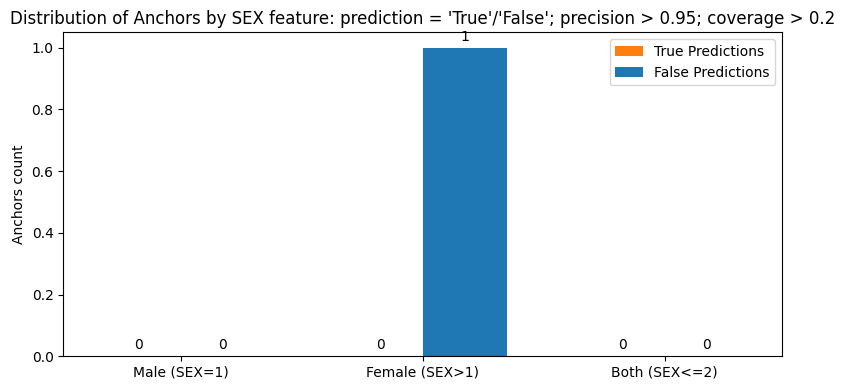

In [27]:
file = 'xai/output/json/lr_ny_anchors_explanations.json'
analyse_anchors(file)

### État de New York - modèle XGBoost

Total of test data:  10303
Total of anchors of men:  1477
Total of anchors of women:  1428
For true predictions: {'SEX <= 1.00': 1335, 'SEX <= 2.00': 334, '1.00 < SEX <= 2.00': 2} 
For false predictions: {'SEX > 1.00': 985, 'SEX <= 2.00': 129, '1.00 < SEX <= 2.00': 104, 'SEX <= 1.00': 16}


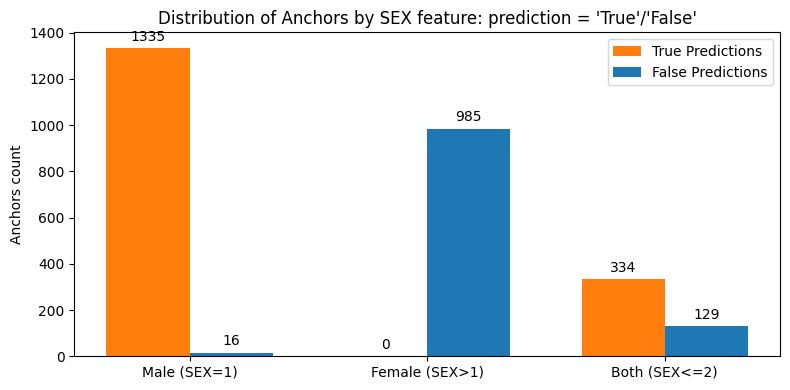

For true predictions and coverage > 0.2: {'SEX <= 1.00': 1} 
For false predictions and coverage > 0.2: {'SEX <= 2.00': 10}


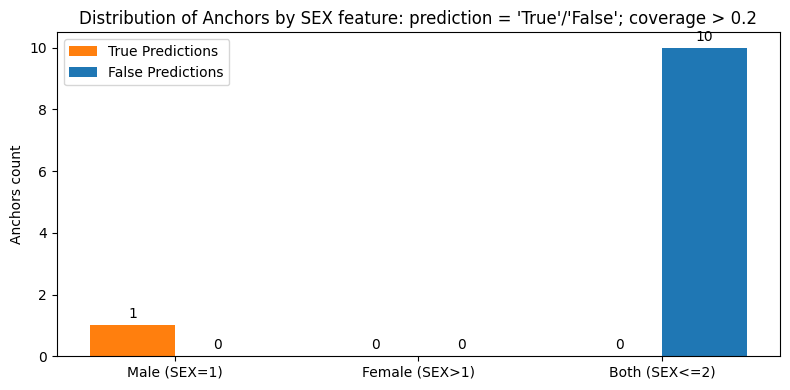

For true predictions and precision > 0.95: {'SEX <= 1.00': 744, 'SEX <= 2.00': 19, '1.00 < SEX <= 2.00': 1} 
For false predictions and precision > 0.95: {'SEX > 1.00': 928, 'SEX <= 2.00': 18, '1.00 < SEX <= 2.00': 28, 'SEX <= 1.00': 4}


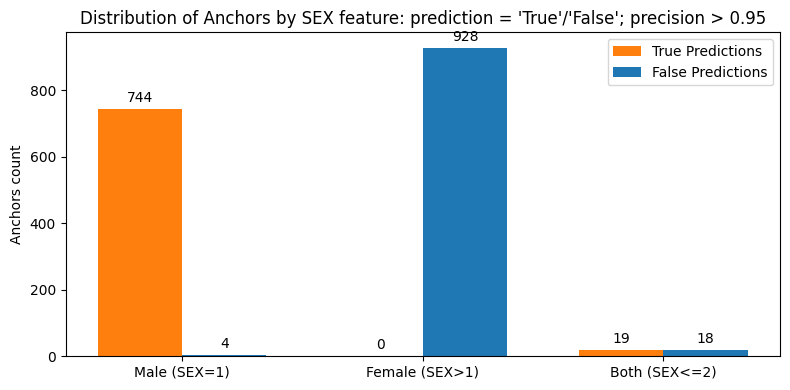

For true predictions and num_features <= 3: {'SEX <= 1.00': 7} 
For false predictions and num_features <= 3: {'SEX > 1.00': 421, '1.00 < SEX <= 2.00': 1, 'SEX <= 1.00': 1, 'SEX <= 2.00': 1}


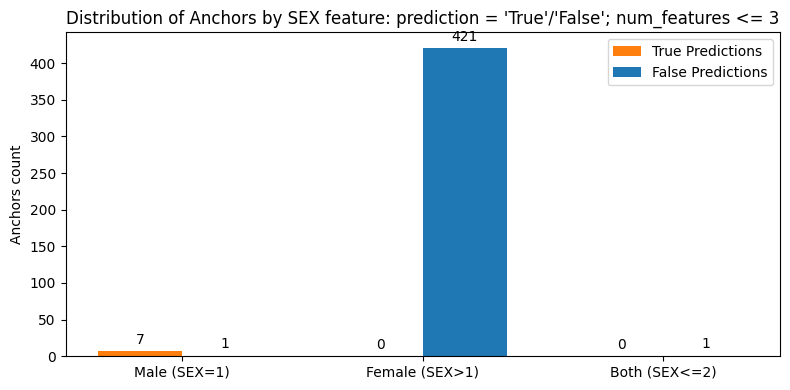

For true predictions and precision > 0.95 and coverage > 0.2: {} 
For false predictions and precision > 0.95 and coverage > 0.2: {}


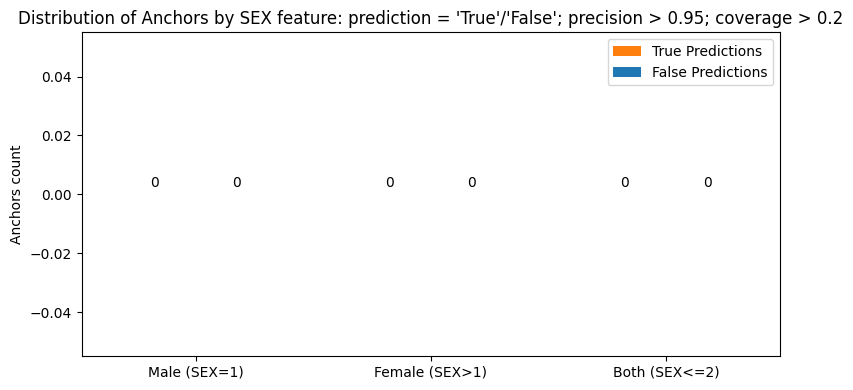

In [26]:
file = 'xai/output/json/xg_ny_anchors_explanations.json'
analyse_anchors(file, 'num')

In [18]:
with open(file, 'r', encoding='utf-8') as f:
    df = pd.read_json(f)
df = df.T
df.shape

(19567, 6)

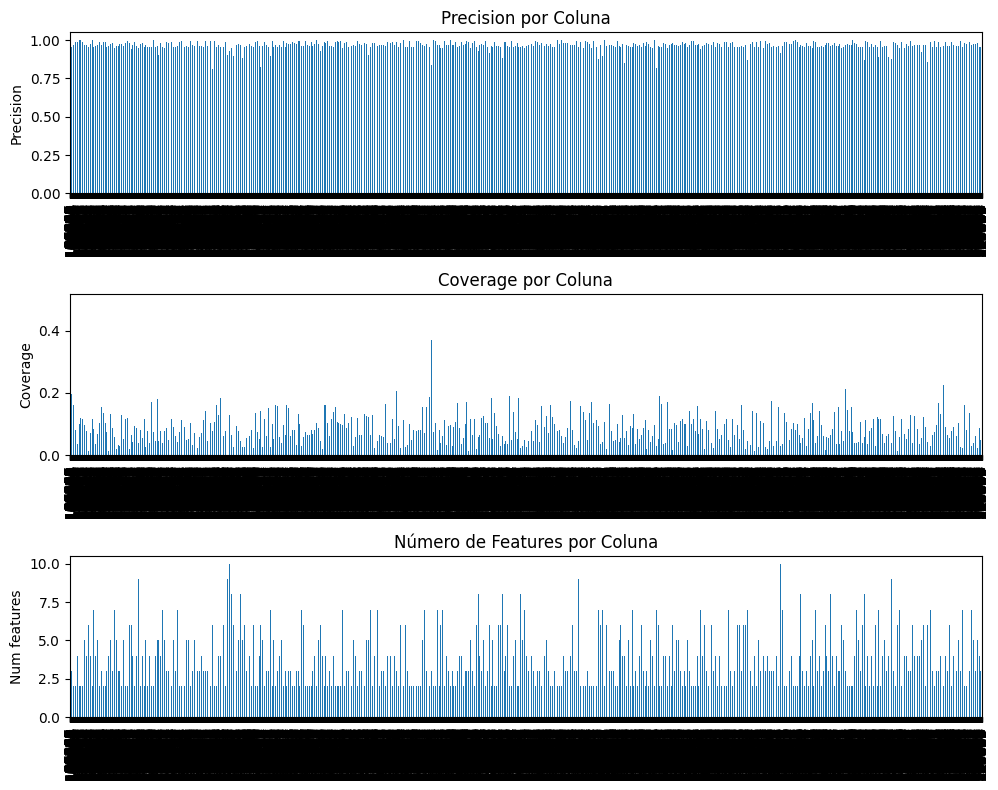

In [19]:
# Plotando precision e coverage
plt.figure(figsize=(10, 8))

# Plot para precision
plt.subplot(3, 1, 1)
df['precision'].plot(kind='bar', title='Precision por Coluna')
plt.ylabel('Precision')

# Plot para coverage
plt.subplot(3, 1, 2)
df['coverage'].plot(kind='bar', title='Coverage por Coluna')
plt.ylabel('Coverage')

# Plot para coverage
plt.subplot(3, 1, 3)
df['features'].apply(len).plot(kind='bar', title='Número de Features por Coluna')  # Calcula o tamanho de cada lista
plt.ylabel('Num features')

plt.tight_layout()
plt.show()

In [20]:
def filtrar_metricas(df, min_precision=0.8, min_coverage=0.3, top_n=100):
    """
    Filtra o DataFrame por precision e coverage, convertendo tipos se necessário.
    
    Args:
        df: DataFrame a ser filtrado
        min_precision: valor mínimo de precision
        min_coverage: valor mínimo de coverage
        top_n: número de top resultados para retornar
        
    Returns:
        Tuple: (df_filtrado, top_precision, top_coverage)
    """
    try:
        # Verificar e converter tipos
        if df['precision'].dtype == 'object':
            df['precision'] = pd.to_numeric(df['precision'], errors='coerce')
        if df['coverage'].dtype == 'object':
            df['coverage'] = pd.to_numeric(df['coverage'], errors='coerce')
        
        # Remover valores inválidos
        df = df.dropna(subset=['precision', 'coverage'])
        
        # Aplicar filtros
        mask = (df['precision'] >= min_precision) & (df['coverage'] >= min_coverage)
        df_filtrado = df[mask].copy()
        
        # Obter tops
        top_precision = df.nlargest(top_n, 'precision')
        top_coverage = df.nlargest(top_n, 'coverage')
        
        return df_filtrado, top_precision, top_coverage
        
    except Exception as e:
        print(f"Erro ao filtrar: {str(e)}")
        return None, None, None


df_filtrado, top_prec, top_cov = filtrar_metricas(df)

In [21]:
df_filtrado

,row_num,prediction,precision,coverage,array_anchors,features
59730,59730,0,0.842746,0.3045,"[4, 3, 2, 1]","[{'feature_name': 'OCCP', 'feature_value': 402..."
187400,187400,0,0.834090,0.3697,"[0, 7, 2]","[{'feature_name': 'AGEP', 'feature_value': 40,..."
136423,136423,0,0.864718,0.3205,"[4, 7, 2, 1]","[{'feature_name': 'OCCP', 'feature_value': 422..."


In [22]:
for i in df_filtrado['features']:
    print(i)
    #print(df_filtrado[i])

[{'feature_name': 'OCCP', 'feature_value': 4020, 'feature_weight': None, 'feature_ranges': 'OCCP > 2014.00', 'feature_rank': 1}, {'feature_name': 'MAR', 'feature_value': 4, 'feature_weight': None, 'feature_ranges': 'MAR > 1.00', 'feature_rank': 2}, {'feature_name': 'SCHL', 'feature_value': 20, 'feature_weight': None, 'feature_ranges': 'SCHL <= 21.00', 'feature_rank': 3}, {'feature_name': 'COW', 'feature_value': 3, 'feature_weight': None, 'feature_ranges': 'COW <= 3.00', 'feature_rank': 4}]
[{'feature_name': 'AGEP', 'feature_value': 40, 'feature_weight': None, 'feature_ranges': 'AGEP <= 42.00', 'feature_rank': 1}, {'feature_name': 'WKHP', 'feature_value': 35, 'feature_weight': None, 'feature_ranges': 'WKHP <= 40.00', 'feature_rank': 2}, {'feature_name': 'SCHL', 'feature_value': 21, 'feature_weight': None, 'feature_ranges': 'SCHL <= 21.00', 'feature_rank': 3}]
[{'feature_name': 'OCCP', 'feature_value': 4220, 'feature_weight': None, 'feature_ranges': 'OCCP > 4110.00', 'feature_rank': 1}, 